In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (10, 4)

In [3]:
df_eda = pd.read_csv("src/data/airbnb_madrid_clean_final.csv")
df_eda

,host_response_time,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,review_score_mean,review_tier
0,within an hour,True,True,Sol,Entire rental unit,Entire home/apt,2,1.0,1.0,2.0,157.0,5,50,5.0,50.0,16,46,76,173,1,1,4.71,4.88,4.82,4.78,4.90,4.69,4.796667,Alta (4.5–4.8]
1,within an hour,True,True,Universidad,Entire rental unit,Entire home/apt,2,1.0,1.0,3.0,143.0,5,50,5.0,50.0,10,40,66,53,4,1,4.71,4.90,4.87,4.81,4.88,4.59,4.793333,Alta (4.5–4.8]
2,within an hour,True,True,Justicia,Private room in rental unit,Private room,4,1.5,1.0,2.0,65.0,1,30,1.0,30.0,4,16,34,249,41,4,4.78,4.46,4.80,4.86,4.97,4.60,4.745000,Alta (4.5–4.8]
3,within an hour,True,True,Universidad,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,116.0,30,360,30.0,1125.0,3,3,30,36,1,0,4.49,4.42,4.43,4.40,4.60,4.09,4.405000,Media (4.0–4.5]
4,within an hour,True,True,Universidad,Entire rental unit,Entire home/apt,2,1.0,1.0,2.0,79.0,30,360,28.6,1125.0,0,12,42,31,2,0,4.65,4.55,4.80,4.71,4.87,4.10,4.613333,Alta (4.5–4.8]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15020,within an hour,True,True,Almenara,Private room in rental unit,Private room,2,1.0,1.0,1.0,62.0,1,365,1.0,365.0,21,39,39,2,2,2,5.00,5.00,5.00,5.00,5.00,5.00,5.000000,Excelente (>4.8)
15021,within an hour,True,True,Palacio,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,194.0,4,365,3.8,365.0,24,54,84,4,4,4,5.00,5.00,5.00,5.00,5.00,5.00,5.000000,Excelente (>4.8)
15022,within an hour,True,True,San Diego,Entire rental unit,Entire home/apt,6,1.0,2.0,4.0,154.0,1,365,1.0,365.0,17,39,69,1,1,1,5.00,5.00,5.00,5.00,5.00,5.00,5.000000,Excelente (>4.8)
15023,within an hour,False,True,Apostol Santiago,Private room in rental unit,Private room,2,0.5,1.0,1.0,34.0,1,365,1.0,365.0,10,28,58,1,1,1,5.00,5.00,5.00,5.00,5.00,5.00,5.000000,Excelente (>4.8)


## 1) EDA univariante

Objetivo: entender distribuciones y detectar outliers.

Sugerencia: para "price", también miramos percentiles y una versión recortada (p99) para que la gráfica se entienda.

count    15025.000000
mean       145.204925
std        371.212444
min          8.000000
50%        112.000000
75%        162.000000
90%        240.000000
95%        315.000000
99%        586.520000
max      25654.000000
Name: price, dtype: float64


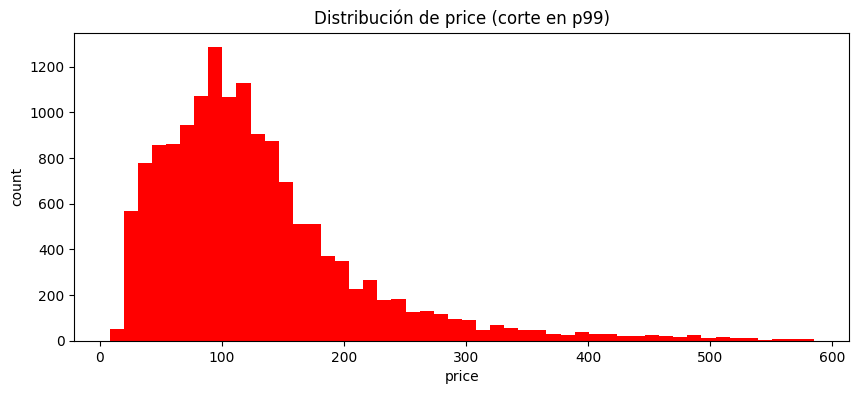

In [4]:
# Price: resumen
p = df_eda['price']
print(p.describe(percentiles=[.5,.75,.9,.95,.99]))

# Histograma (con corte en p99) -> Que sino se va muchisimo por si hay algun atípico
cut = p.quantile(0.99)
plt.figure()
plt.hist(p[p<=cut], bins=50, color='red')
plt.title('Distribución de price (corte en p99)')
plt.xlabel('price')
plt.ylabel('count')
plt.show()

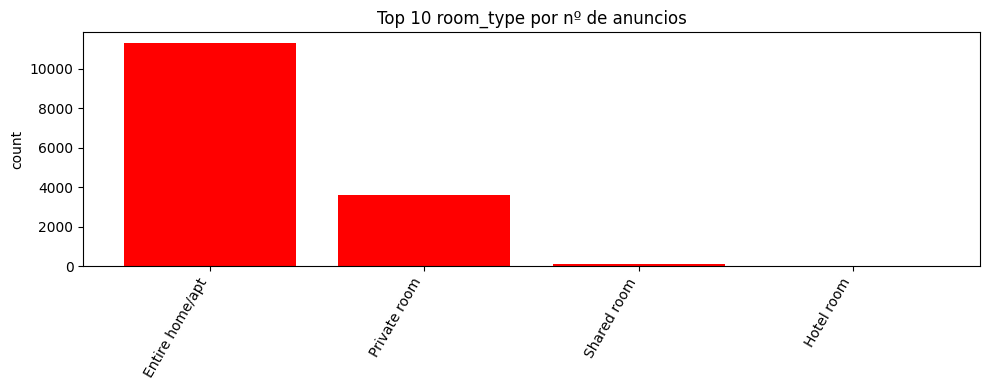

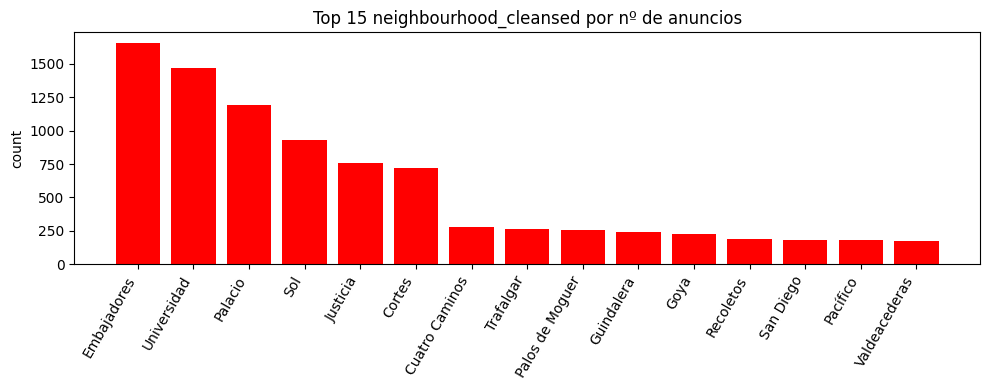

In [5]:
# Room type y neighbourhood (Top 15)

for col, topn in [('room_type', 10), ('neighbourhood_cleansed', 15)]:
    if col in df_eda.columns:
        vc = df_eda[col].value_counts().head(topn)
        plt.figure()
        plt.bar(vc.index.astype(str), vc.values, color='red')
        plt.title(f'Top {topn} {col} por nº de anuncios')
        plt.xticks(rotation=60, ha='right')
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()

## 2) EDA bivariante y Hipótesis

Cada persona yo veo que se quede con 2–3 hipótesis.

### Hipótesis 1 — El precio cambia según el barrio
- He elegido la mediana (más robusta con outliers).

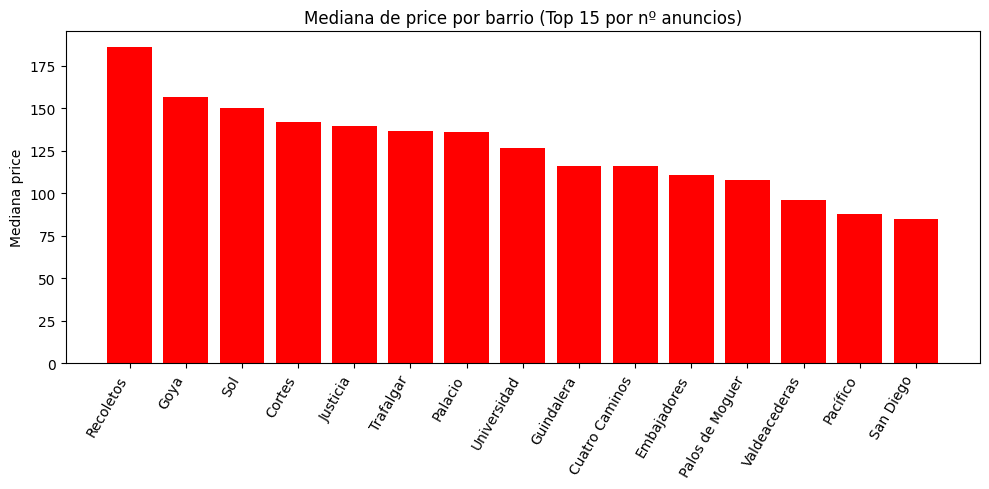

,median_price
neighbourhood_cleansed,
Recoletos,186.0
Goya,156.5
Sol,150.0
Cortes,142.0
Justicia,139.5
Trafalgar,136.5
Palacio,136.0
Universidad,126.5
Guindalera,116.0


In [6]:
# H1: price por barrio (top 15 por nº de anuncios)
col = 'neighbourhood_cleansed'
if col in df_eda.columns:
    top = df_eda[col].value_counts().head(15).index
    tmp = df_eda[df_eda[col].isin(top)].groupby(col)['price'].median().sort_values(ascending=False)

    plt.figure(figsize=(10,5))
    plt.bar(tmp.index.astype(str), tmp.values, color='red')
    plt.title('Mediana de price por barrio (Top 15 por nº anuncios)')
    plt.xticks(rotation=60, ha='right')
    plt.ylabel('Mediana price')
    plt.tight_layout()
    plt.show()

    # Tabla apoyo
    display(tmp.to_frame('median_price'))

Los barrios céntricos como Salamanca y Centro presentan los precios medios más altos, mientras que barrios periféricos muestran precios significativamente más bajos, indicando una fuerte influencia de la ubicación en el precio por noche.

### Hipótesis 2 — El tipo de alojamiento influye en el precio ("room_type")

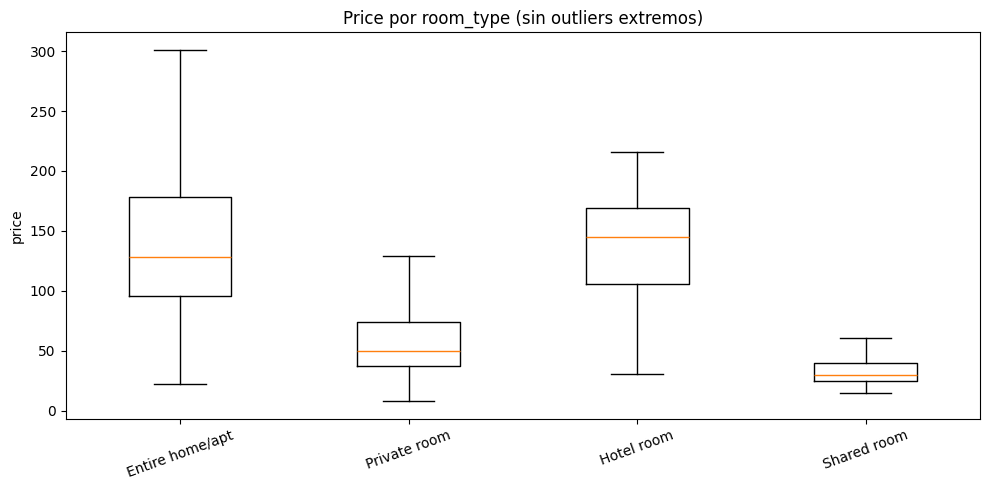

,median_price
room_type,
Hotel room,145.0
Entire home/apt,129.0
Private room,50.0
Shared room,29.5


In [9]:
# H2: price por room_type (boxplot)
col = 'room_type'
if col in df_eda.columns:
    groups = [df_eda.loc[df_eda[col]==cat, 'price'].values for cat in df_eda[col].dropna().unique()]
    labels_ = [str(cat) for cat in df_eda[col].dropna().unique()]

    # recorte para visibilidad (p99)
    cut = df_eda['price'].quantile(0.99)
    df_cut = df_eda[df_eda['price']<=cut]

    groups = [df_cut.loc[df_cut[col]==cat, 'price'].values for cat in df_cut[col].dropna().unique()]
    labels_ = [str(cat) for cat in df_cut[col].dropna().unique()]

    plt.figure(figsize=(10,5))
    plt.boxplot(groups, tick_labels=labels_, showfliers=False, )
    plt.title('Price por room_type (sin outliers extremos)')
    plt.ylabel('price')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

    # Mediana por tipo
    display(df_eda.groupby(col)['price'].median().sort_values(ascending=False).to_frame('median_price'))

Los alojamientos de tipo “Entire home/apt” son considerablemente más caros que las habitaciones privadas o compartidas, lo que sugiere que la privacidad es uno de los principales factores de precio.

### Hipótesis 3 — A más capacidad ("accommodates"), mayor precio

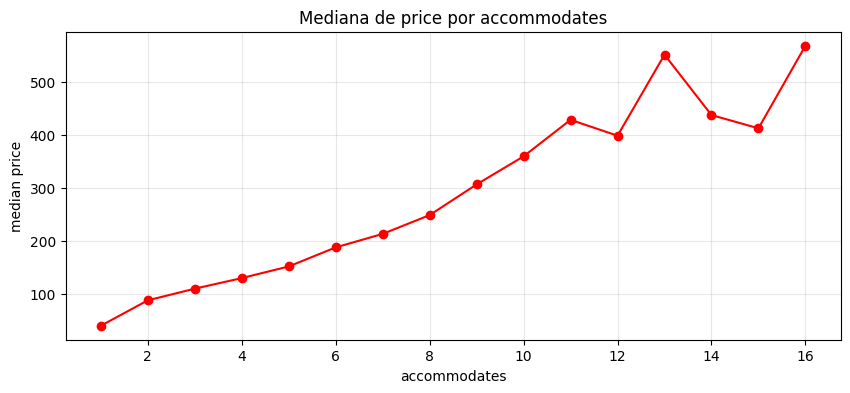

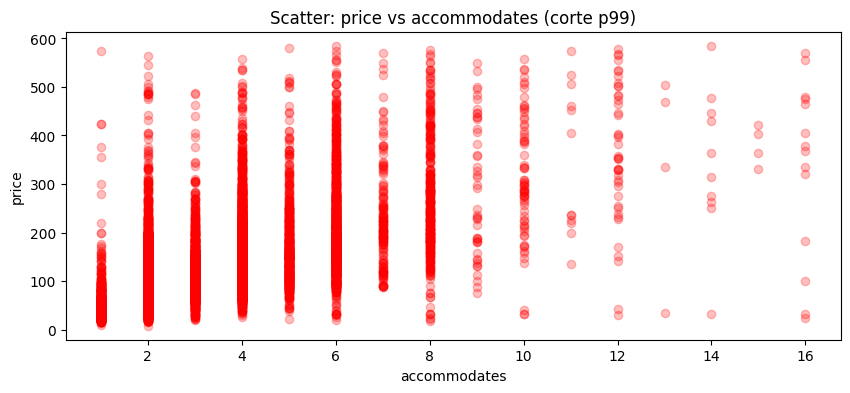

In [12]:
# H3: price vs accommodates
if 'accommodates' in df_eda.columns:
    # mediana por accommodates
    tmp = df_eda.groupby('accommodates')['price'].median()

    plt.figure()
    plt.plot(tmp.index, tmp.values, marker='o', color='red')
    plt.title('Mediana de price por accommodates')
    plt.xlabel('accommodates')
    plt.ylabel('median price')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Scatter (con corte p99)
    cut = df_eda['price'].quantile(0.99)
    df_cut = df_eda[df_eda['price']<=cut]

    plt.figure()
    plt.scatter(df_cut['accommodates'], df_cut['price'], alpha=0.25, color='red')
    plt.title('Scatter: price vs accommodates (corte p99)')
    plt.xlabel('accommodates')
    plt.ylabel('price')
    plt.show()

A mayor capacidad del alojamiento, mayor es el precio medio por noche, aunque el incremento no es proporcional, indicando economías de escala para grupos grandes.

### Hipótesis 4 — Mejor valoración (reviews) se asocia a mayor precio

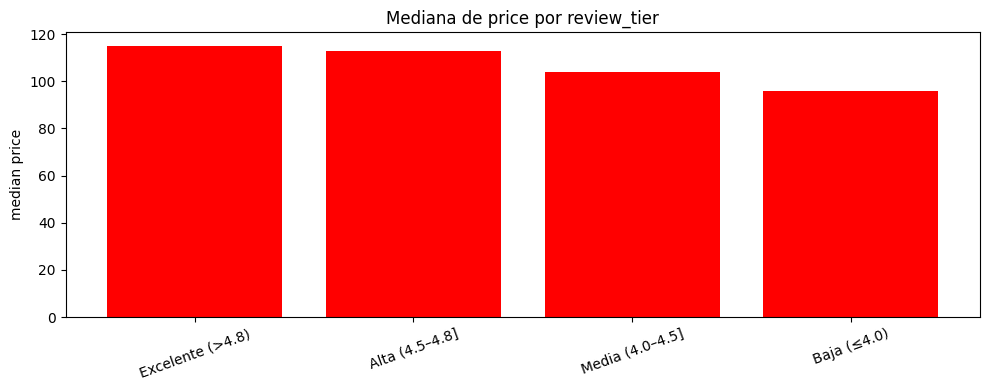

,median_price
review_tier,
Excelente (>4.8),115.0
Alta (4.5–4.8],113.0
Media (4.0–4.5],104.0
Baja (≤4.0),96.0


In [13]:
# H4: price por review_tier
if 'review_tier' in df_eda.columns:
    tmp = df_eda.groupby('review_tier')['price'].median().sort_values(ascending=False)

    plt.figure(figsize=(10,4))
    plt.bar(tmp.index.astype(str), tmp.values, color='red')
    plt.title('Mediana de price por review_tier')
    plt.ylabel('median price')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()

    display(tmp.to_frame('median_price'))

Los alojamientos con mejores valoraciones medias tienden a tener precios más altos, lo que indica que la calidad percibida y la confianza del usuario influyen en el precio.

### Hipótesis 5 — Host verificado ("host_identity_verified") vs precio

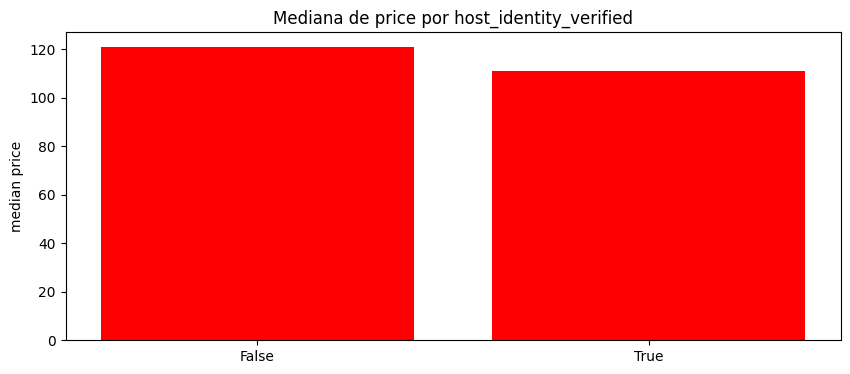

,median_price
host_identity_verified,
False,121.0
True,111.0


In [14]:
# H5: host_identity_verified
col = 'host_identity_verified'
if col in df_eda.columns:
    tmp = df_eda.groupby(col)['price'].median()

    plt.figure()
    plt.bar([str(x) for x in tmp.index], tmp.values, color='red')
    plt.title('Mediana de price por host_identity_verified')
    plt.ylabel('median price')
    plt.show()

    display(tmp.to_frame('median_price'))

El análisis muestra que los alojamientos con hosts no verificados tienen una mediana de precio ligeramente superior a los verificados, lo cual resulta contraintuitivo. Esto indica que la verificación del host, por sí sola, no determina el precio del alojamiento. 



### Hipótesis 6 — Restricciones de noches ("minimum_nights") afectan al precio

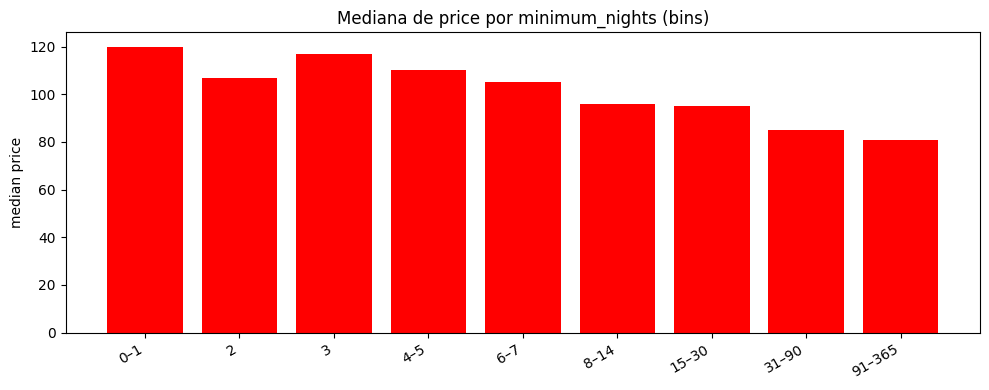

,median_price
min_nights_bin,
0–1,120.0
2,107.0
3,117.0
4–5,110.0
6–7,105.0
8–14,96.0
15–30,95.0
31–90,85.0
91–365,81.0


In [16]:
# H6: minimum_nights vs price
if 'minimum_nights' in df_eda.columns:
    # Agrupar min_nights en bins para legibilidad
    x = df_eda['minimum_nights']
    bins = [0,1,2,3,5,7,14,30,90,365, np.inf]
    labels = ['0–1','2','3','4–5','6–7','8–14','15–30','31–90','91–365','>365']
    df_eda['min_nights_bin'] = pd.cut(x, bins=bins, labels=labels, right=True, include_lowest=True)

    tmp = df_eda.groupby('min_nights_bin', observed=True)['price'].median()

    plt.figure(figsize=(10,4))
    plt.bar(tmp.index.astype(str), tmp.values, color='red')
    plt.title('Mediana de price por minimum_nights (bins)')
    plt.ylabel('median price')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

    display(tmp.to_frame('median_price'))

A mayor número mínimo de noches, menor precio mediano por noche, lo que indica una estrategia de descuento implícito para estancias largas.


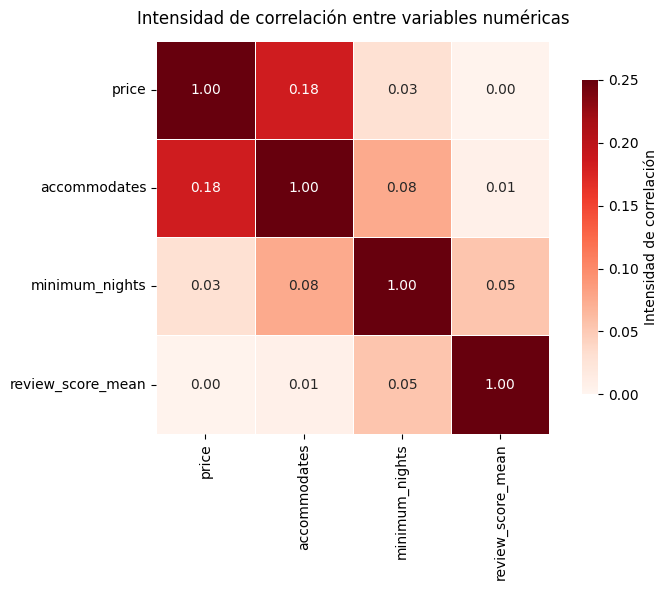

In [17]:
# Selección de variables numéricas relevantes (las que saldrán en el análisis, si quereis las cambiamos vaya)
num_cols = [
    'price',
    'accommodates',
    'minimum_nights',
    'review_score_mean'
]
df_num = df_eda[num_cols].dropna()

# Matriz de correlación
corr = df_num.corr()

plt.figure(figsize=(8,6))

sns.heatmap(
    corr.abs(),
    annot=True,
    fmt=".2f",
    cmap=sns.color_palette("Reds", as_cmap=True),
    vmin=0,
    vmax=0.25,       
    linewidths=0.7,
    linecolor='white',
    square=True,
    cbar_kws={
        "shrink": 0.8,
        "label": "Intensidad de correlación"
    }
)

plt.title("Intensidad de correlación entre variables numéricas", pad=12)
plt.tight_layout()
plt.show()


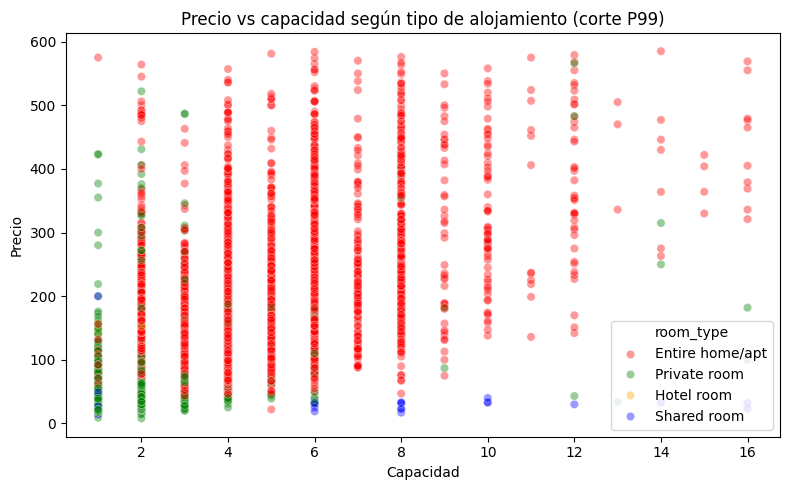

In [18]:
# Corte en percentil 99 para evitar outliers extremos (se va mucho)
cut = df_eda['price'].quantile(0.99)

cambio_colores = {
    'Entire home/apt': 'red',   
    'Hotel room': 'orange',
    'Private room': 'green',
    'Shared room': 'blue'         
}

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df_eda[df_eda['price'] <= cut],
    x='accommodates',
    y='price',
    hue='room_type',
    palette=cambio_colores,
    alpha=0.4
)

plt.title("Precio vs capacidad según tipo de alojamiento (corte P99)")
plt.xlabel("Capacidad")
plt.ylabel("Precio")
plt.tight_layout()
plt.show()



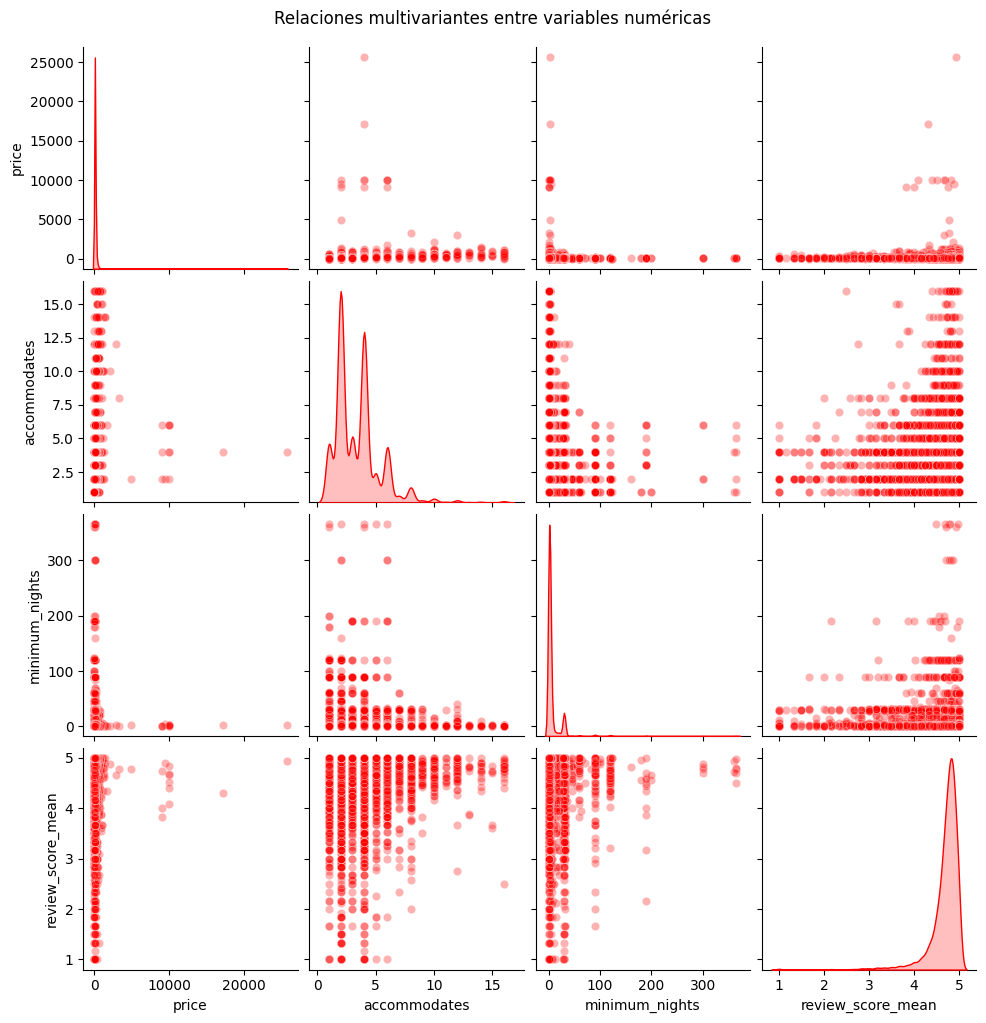

In [19]:
sns.pairplot(
    df_num,
    diag_kind="kde",
    plot_kws={
        'alpha': 0.3,
        'color': 'red'
    },
    diag_kws={
        'color': 'red'
    }
)

plt.suptitle(
    "Relaciones multivariantes entre variables numéricas",
    y=1.02
)
plt.show()
